# A Bayesian Network to model the effects of an epidemic on a nation
### Student: Andrea Rossolini <br> Fundamentals of Artificial Intelligence and Knowledge Representation (mod. 3)

In the following notebook I developed a highly simplified Bayesian network to model the main consequence of a pandemic breakout in a nation, based on its population, density, GDP and so on.

The network is based on the famous SIR model, each letter denotes a state of individuals in a population: 
<ul>
    <li>S: number of susceptible</li>
    <li>I: number of infected</li>
    <li>R: number of removed</li>
</ul>

The last state of this model can be devided in two different states: <i>recovered</i> and <i>dead</i>.
Thanks to this extansion the network that we are suppose to build can be extended with more concepts.

Such a model should be represented with a probabilistic reasoning model over time, to simplify this process I decided to model the consequence of a pandemic after defined period of time. Thus the following network represent a static model.

<b>Note</b><br>
The model takes as example the epidemic of COVID-19 and its effects on a nation in a time frame of two months.
The model, as said before, is over semplified, it does not take into account the economic damages that an epidemy can bring to a country, the social behaviour before and after the pandemic, the observance of the rules (social distances, wearing masks, compilance with a possible lockdown and so on), domestic or international turism and so forth.

In this project is used the library <b>pgmpy</b>.<br>
By the fact there not exists complete data from which pgmpy can learn to build the network; I created some artificious values, while other are taken from different sources (see at the bottom).
To simplify this work some continous variables had been devided in group.

In [2]:
import numpy as np
from scipy.stats import beta
from scipy.integrate import simps
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

from IPython.display import Image

Starting from the SIRD model explained above we can infer different features.<br>

<!-- bambini sotto i 12 mesi, persone con particolari sistemi immunitari, persone che vivono fenomeni di isolamento (hikikomori, gravi fenomeni di ipocondria con ricadute psicologiche, ecc..)-->

<br>
<ul>
    <li><b>Dens</b> = Density (pop./km^2):</li>
        <ul>
            <li>very low (< 30 e.g. Canada) 48/195</li>
            <li>low ([30,100] e.g. Brazil or USA)  64/195</li>
            <li>Medium ([100,300] e.g. Italy) 55/195</li>
            <li>High ([300,600] e.g. Netherlands) 18/195</li>
            <li>very high (> 600 e.g. Bangladesh) 10/195</li>
        </ul>
    <li><b>Pop</b> = population
        <ul>
            <li>very low (< 1,000,000 e.g. Luxemburg) 39/195</li>
            <li>low ([1, 10] million e.g. Austria) 66/195</li>
            <li>medium ([10, 100] million e.g. Italy) 76/195</li>
            <li>High ([100m, 1b]  e.g. Brazil) 12/195</li>
            <li>Very High ([> 1b] e.g. India) 2/195</li>
        </ul>
    </li>
    <li><b>RP</b>  = Restriction Policies
        <ul>
            <li>None   (e.g. herd immunity)</li>
            <li>Light  (e.g. mask mandatory in public spaces, ban on gathering)</li>
            <li>Medium (e.g. Lockdown with exceptions for workers, travel restrictions)</li>
            <li>Severe (e.g. Lockdown including productive activities, country isolation)</li>
            <li>Extreme (e.g. Martial law)</li>
        </ul>
    </li>
    <li><b>GDP</b> = Gross Domesti product</li>
    <ul>
        <li>Low  (< 100b e.g. Luxemburg) 131/165</li>
        <li>Medium ([100b, 1t] e.g. Netherlands) 48/195</li>
        <li>High (> 1t e.g. Italy) 16/195</li>
    </ul>
    <li><b>S</b>  = Susceptible: percentage of population that can get sick (people cannot be susceptible for different reasons as immunity, life style, age ...)</li>
    <ul>
        <li>medium (at least 75% of population)</li>
        <li>high (at least 90% " ")</li>
    </ul>
    <li><b>Age</b> = Average Age</li>
    <ul>
        <li>young  (< 20) 40/230 </li>
        <li>avg    ([20, 40]) 140/230</li>
        <li>old    (> 40) 50/230</li>
    </ul>
    <li><b>I</b> = percentage of susceptibles Infected</li>
    <ul>
        <li> Low (< 0.3% e.g. Mongolia) </li>
        <li> Medium ([0.3,0.8%] e.g. Italy)</li>
        <li> High (>0.8% e.g. USA)</li>
    </ul>
    <li><b>HC</b> = Health Care system overall performances </li>
    <ul>
        <li>weak</li> <-- la probabilità è nel quadernino --!>
        <li>strong</li>
    </ul>
    <li><b>De</b> = Percentage of deaths </li>
    <ul>
        <li>Low  (< 4% of infected died)</li> 
        <li>High (> 4% of infected died)</li>
    </ul>
    <li><b>Re</b> = Percentage of recovered </li>
    <ul>
        <li>Low  (< 50% of infected recovered)</li>
        <li>High (> 50% of infected recovered)</li>
    </ul>
</ul>

It is possible to define the network strucure according to the features defined above. In the following cells it is explained how the network was conceived.

Using pgmpy we can simply wrote:

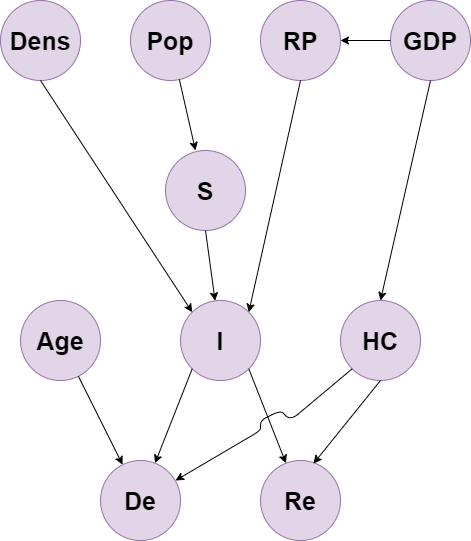

In [8]:
model = BayesianModel([('Dens', 'I'), ('Pop', 'S'), ('GDP', 'RP'), ('GDP', 'HC'),
                       ('RP', 'I'), ('S', 'I'), ('Age', 'De'), ('I', 'De'),
                       ('I', 'Re'), ('HC', 'De'), ('HC', 'Re')])
Image(filename="../res/chart.png")

Now we must define the values for the conditional probability tables: <b> The numbers that we use are rather arbitrary guesses and we do not pretend them to be anyhow realistic.</b>
<br>For the node without parents (density, population, GDP, average age of each country) is simple: I used the data from  [1], [2], [3], [4].

In [3]:
# Defining CPD of nodes without parents
den_cpd = TabularCPD(variable='Dens',variable_card=5, 
                    values=[[0.24615384615384617], [0.3282051282051282], [0.28205128205128205], [0.09230769230769231], [0.05128205128205128]],
                    state_names={'Dens': ['Very_low', 'Low', 'Medium', 'High', 'Very_high']})
pop_cpd = TabularCPD(variable='Pop',variable_card=5, 
                    values=[[0.2], [0.3384615384615385], [0.38974358974358975], [0.06153846153846154], [0.010256410256410256]],
                    state_names={'Pop': ['Very_low', 'Low', 'Medium', 'High', 'Very_high']})
gdp_cpd = TabularCPD(variable='GDP',variable_card=3, 
                    values=[[0.6717948717948717], [0.24615384615384617], [0.08205128205128205]],
                    state_names={'GDP': ['Low', 'Medium', 'High']})
age_cpd = TabularCPD(variable='Age',variable_card=3, 
                    values=[[0.17391304347826086], [0.6086956521739131], [0.21739130434782608]],
                    state_names={'Age': ['Young', 'Avg', 'Old']})

model.add_cpds(den_cpd, pop_cpd, gdp_cpd, age_cpd)

In the following cell <i>Susceptible</i> and <i>Health Care system</i> and <i>Restriction Policies</i> are defined.
The first one is infuenced only by the population and it has no other relation with other net's features.


In [4]:
# Defining CPD of nodes with one parent
sus_cpd = TabularCPD(variable='S',variable_card=2, 
                     values=[[0.3, 0.35, 0.4, 0.45, 0.50], [0.7, 0.65, 0.6, 0.55, 0.5]],
                     evidence=['Pop'],
                     evidence_card=[5],
                     state_names={'S': ['Medium', 'High'],
                                 'Pop': ['Very_low', 'Low', 'Medium', 'High', 'Very_high']})
HC_cpd = TabularCPD(variable='HC',variable_card=2, 
                     values=[[0.83, 0.42, 0.05], [0.17, 0.58, 0.95]],
                     evidence=['GDP'],
                     evidence_card=[3],
                     state_names={'HC': ['Weak', 'Strong'],
                                 'GDP': ['Low', 'Medium', 'High']})
RP_cpd = TabularCPD(variable='RP',variable_card=5,
                     values=[[0.29, 0.21, 0.12], 
                             [0.32, 0.37, 0.28], 
                             [0.19, 0.26, 0.39], 
                             [0.11, 0.13, 0.205], 
                             [0.09, 0.03, 0.005]],
                     evidence=['GDP'],
                     evidence_card=[3],
                     state_names={'RP': ['None', 'Light', 'Normal', 'Severe', 'Extreme'],
                                 'GDP': ['Low', 'Medium', 'High']})

model.add_cpds(sus_cpd, HC_cpd, RP_cpd)

In [5]:
#CANCELLA
S = [0.5, 0.75]
Dens = [1.5, 2, 3, 4, 4.5]
RP = [1, 0.5, 0, -0.5, -1]
min_ = 1.5

res = []
for es in S :
    for d in Dens:
        for rp in RP:
            tmp = es+d+rp
            if tmp < min_ :
                tmp=min_
            res.append(tmp)
print(res)
print(len(res))
res.sort()
for n, elem in enumerate(res):
    if n == 0 or elem != res[n-1] :
        print("{0} - count {1}".format(elem, res.count(elem)))

[3.0, 2.5, 2.0, 1.5, 1.5, 3.5, 3.0, 2.5, 2.0, 1.5, 4.5, 4.0, 3.5, 3.0, 2.5, 5.5, 5.0, 4.5, 4.0, 3.5, 6.0, 5.5, 5.0, 4.5, 4.0, 3.25, 2.75, 2.25, 1.75, 1.5, 3.75, 3.25, 2.75, 2.25, 1.75, 4.75, 4.25, 3.75, 3.25, 2.75, 5.75, 5.25, 4.75, 4.25, 3.75, 6.25, 5.75, 5.25, 4.75, 4.25]
50
1.5 - count 4
1.75 - count 2
2.0 - count 2
2.25 - count 2
2.5 - count 3
2.75 - count 3
3.0 - count 3
3.25 - count 3
3.5 - count 3
3.75 - count 3
4.0 - count 3
4.25 - count 3
4.5 - count 3
4.75 - count 3
5.0 - count 2
5.25 - count 2
5.5 - count 2
5.75 - count 2
6.0 - count 1
6.25 - count 1


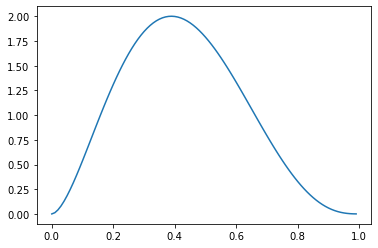

[0.00000000e+00 1.24485088e-02 4.07187791e-02 8.04831586e-02
 1.29411068e-01 1.85805245e-01 2.48305782e-01 3.15769534e-01
 3.87208203e-01 4.61751981e-01 5.38626167e-01 6.17135123e-01
 6.96650697e-01 7.76603527e-01 8.56476301e-01 9.35798395e-01
 1.01414150e+00 1.09111597e+00 1.16636781e+00 1.23957598e+00
 1.31045015e+00 1.37872869e+00 1.44417691e+00 1.50658540e+00
 1.56576867e+00 1.62156379e+00 1.67382918e+00 1.72244356e+00
 1.76730484e+00 1.80832923e+00 1.84545030e+00 1.87861814e+00
 1.90779857e+00 1.93297238e+00 1.95413460e+00 1.97129380e+00
 1.98447143e+00 1.99370122e+00 1.99902851e+00 2.00050967e+00
 1.99821158e+00 1.99221098e+00 1.98259400e+00 1.96945561e+00
 1.95289910e+00 1.93303556e+00 1.90998340e+00 1.88386787e+00
 1.85482059e+00 1.82297902e+00 1.78848609e+00 1.75148965e+00
 1.71214208e+00 1.67059981e+00 1.62702289e+00 1.58157455e+00
 1.53442072e+00 1.48572967e+00 1.43567152e+00 1.38441780e+00
 1.33214105e+00 1.27901438e+00 1.22521102e+00 1.17090389e+00
 1.11626518e+00 1.061465

In [6]:
#CANCELLA
from matplotlib import pyplot as plt 
from scipy.stats import beta

b = 3.75
a = 2.75

x = np.arange(0.0, 1, 0.01)
y = beta.pdf(x,a,b)
plt.plot(x,y)
plt.show()
#x = np.random.beta(2.5,3.75,lim)
print(y)
print(len(y))

In [111]:
S = [0.5, 0.75]
Dens = [1.5, 2, 3, 4, 4.5]
RP = [1, 0.5, 0, -0.5, -1]
min_ = 1.5
max_ = 6

res = []
for es in S :
    for d in Dens:
        for rp in RP:
            tmp = es+d+rp
            if tmp < min_ :
                tmp=min_
            if tmp > max_ :
                tmp=max_
            res.append(tmp)

low, med, hig = [], [], []
x = np.arange(0.01, 1, 0.01)
b = 3.5
for a in res :
    y = beta.pdf(x,a,b)
    low.append(round(simps(y[:34])/100, 3))   #Simpson's rule
    med.append(round(simps(y[33:67])/100, 3))
    hig.append(round(simps(y[66:])/100, 3))
    
    
### CANCELLA LE STAMPE ###    
print(low)
print('___'*20)
print(med)
print('___'*20)
print(hig)
print('**'*20)
print(max(low))
print(max(med))
print(max(hig))
print('**'*20)
print(min(low))
print(min(med))
print(min(hig))
print('**'*20)
### CANCELLA LE STAMPE ###

[0.276, 0.372, 0.488, 0.618, 0.618, 0.201, 0.276, 0.372, 0.488, 0.618, 0.101, 0.143, 0.201, 0.276, 0.372, 0.048, 0.07, 0.101, 0.143, 0.201, 0.033, 0.048, 0.07, 0.101, 0.143, 0.236, 0.321, 0.427, 0.552, 0.618, 0.17, 0.236, 0.321, 0.427, 0.552, 0.084, 0.12, 0.17, 0.236, 0.321, 0.04, 0.058, 0.084, 0.12, 0.17, 0.033, 0.04, 0.058, 0.084, 0.12]
____________________________________________________________
[0.582, 0.525, 0.442, 0.335, 0.335, 0.614, 0.582, 0.525, 0.442, 0.335, 0.619, 0.625, 0.614, 0.582, 0.525, 0.573, 0.601, 0.619, 0.625, 0.614, 0.54, 0.573, 0.601, 0.619, 0.625, 0.601, 0.557, 0.487, 0.392, 0.335, 0.622, 0.601, 0.557, 0.487, 0.392, 0.611, 0.624, 0.622, 0.601, 0.557, 0.557, 0.588, 0.611, 0.624, 0.622, 0.54, 0.557, 0.588, 0.611, 0.624]
____________________________________________________________
[0.142, 0.103, 0.069, 0.041, 0.041, 0.185, 0.142, 0.103, 0.069, 0.041, 0.28, 0.232, 0.185, 0.142, 0.103, 0.379, 0.329, 0.28, 0.232, 0.185, 0.427, 0.379, 0.329, 0.28, 0.232, 0.163, 0.122, 0

In [113]:
# We use the lists found above to generate a reasonable Infected's CPD
I_cpd = TabularCPD(variable='I',variable_card=3, 
                     values=[low, med, hig],
                     evidence=['Dens', 'RP', 'S'],
                     evidence_card=[5,5,2],
                     state_names={'I':['Low','Medium', 'High'],
                                  'Dens': ['Very_low', 'Low', 'Medium', 'High', 'Very_high'],
                                  'RP': ['None', 'Light', 'Normal', 'Severe', 'Extreme'],
                                  'S': ['Medium', 'High']})
model.add_cpds(I_cpd)

In [114]:
Re_cpd = TabularCPD(variable='Re',variable_card=2, 
                     values=[[0.4,0.2,0.5,0.3,0.6,0.4], [0.6,0.8,0.5,0.7,0.4,0.6]],
                     evidence=['I', 'HC'],
                     evidence_card=[3,2],
                     state_names={'Re': ['Low', 'High'],
                                  'I': ['Low', 'Medium', 'High'],
                                  'HC': ['Weak', 'Strong']})

De_cpd = TabularCPD(variable='De', variable_card=2,
                   values=[[0.40,0.85,0.50,0.80,0.60,0.75,
                            0.50,0.80,0.40,0.75,0.30,0.70,
                            0.40,0.75,0.30,0.70,0.20,0.65],
                           [0.60,0.15,0.50,0.20,0.40,0.25,
                            0.50,0.20,0.60,0.25,0.70,0.30,
                            0.60,0.25,0.70,0.30,0.80,0.35]],
                   evidence=['Age','I','HC'],
                   evidence_card=[3,3,2],
                   state_names={'De': ['Low','High'],
                                'Age': ['Young', 'Avg', 'Old'],
                                'I': ['Low', 'Medium', 'High'],
                                'HC': ['Weak', 'Strong']})

model.add_cpds(De_cpd, Re_cpd)

In [17]:
print('Check model: {0}\n'.format(model.check_model()))
for cpd in model.get_cpds():
    print('CPT -- {0}:'.format(cpd.variable))
    print(cpd, '\n')

Check model: True

CPT -- Dens:
+-----------------+-----------+
| Dens(Very_low)  | 0.246154  |
+-----------------+-----------+
| Dens(Low)       | 0.328205  |
+-----------------+-----------+
| Dens(Medium)    | 0.282051  |
+-----------------+-----------+
| Dens(High)      | 0.0923077 |
+-----------------+-----------+
| Dens(Very_high) | 0.0512821 |
+-----------------+-----------+ 

CPT -- Pop:
+----------------+-----------+
| Pop(Very_low)  | 0.2       |
+----------------+-----------+
| Pop(Low)       | 0.338462  |
+----------------+-----------+
| Pop(Medium)    | 0.389744  |
+----------------+-----------+
| Pop(High)      | 0.0615385 |
+----------------+-----------+
| Pop(Very_high) | 0.0102564 |
+----------------+-----------+ 

CPT -- GDP:
+-------------+-----------+
| GDP(Low)    | 0.671795  |
+-------------+-----------+
| GDP(Medium) | 0.246154  |
+-------------+-----------+
| GDP(High)   | 0.0820513 |
+-------------+-----------+ 

CPT -- Age:
+------------+----------+
| Age(Young

## Network Analysis
<i>Pgmpy</i> allows to easly investigate the propoerties of the network, indeed it is possible to individuate flows of probabilistic influence, active trials, check the conditionals independence relations between features of the Bayesian network and more over.

The investigation can be performed on <b>single nodes</b>, for example:

In [41]:
#Checking Cardinality of a Node (Population)
card_pop = model.get_cardinality('Pop')

#Getting Children of a Node (Infection)
child_Inf = model.get_children('I')

#Getting predecessors of a node (Infection)
pred_Inf = list(model.predecessors("I"))

#Getting successors of a node
succ_HC =list(model.successors("HC"))

#Getting Markov Blanket of a node
'''The Markov Blanket consists in all the parents of the node,
   its children and its children's (other) parents'''
mb_Inf = model.get_markov_blanket('I')

# Getting the local independencies of one or more nodes.
model.local_independencies('De')
local_inds = model.local_independencies(['I','De'])

#Individuate active trials
'''If influence can flow from X to Y via Z,
   the trail X⇌Z⇌Y is active'''
act_trials_inf = model.active_trail_nodes('I', observed='GDP')

print(f'The cardinality of the node \'population\' is\n{card_pop}\n')
print(f'The children of the node \'Infected\' are \n{child_Inf}\n')
print(f'The predecessors of the node \'Infected\' are \n{pred_Inf}\n')
print(f'The successors of the node \'Health Care\' are \n{succ_HC}\n')
print(f'The Markov Blanket of the node \'Infected\' is \n{mb_Inf}\n')
print(f'The local independencies of the nodes \'Infected\' and \'Deaths\' are\n{local_inds}\n')
print(f'The active trials of the node \'Infected\', considering \'GDP\'\n{act_trials_inf}\n')

The cardinality of the node 'population' is
5

The children of the node 'Infected' are 
['De', 'Re']

The predecessors of the node 'Infected' are 
['Dens', 'RP', 'S']

The successors of the node 'Health Care' are 
['De', 'Re']

The Markov Blanket of the node 'Infected' is 
['RP', 'De', 'Dens', 'Age', 'Re', 'HC', 'S']

The local independencies of the nodes 'Infected' and 'Deaths' are
(I _|_ HC, Age, Pop, GDP | RP, Dens, S)
(De _|_ RP, Dens, Re, GDP, Pop, S | HC, Age, I)

The active trials of the node 'Infected', considering 'GDP'
{'I': {'RP', 'De', 'Dens', 'Pop', 'I', 'Re', 'S'}}



The investigation can be performed <b>globally</b> on the whole network, like in the following cells:

In [42]:
#Getting the list of leaves of the network
leaves = model.get_leaves()

#Getting the list of roots of the network
roots = model.get_roots()

#Getting the number of nodes of the network
nodes = model.number_of_nodes()

print(f'the number of nodes of the network is {nodes}')
print(f'the leaves of the network are {leaves}')
print(f'the roots of the network are {roots}')

the number of nodes of the network is 10
the leaves of the network are ['De', 'Re']
the roots of the network are ['Dens', 'Pop', 'GDP', 'Age']


In [33]:
#get all independencies of the network
model.get_independencies()

(Dens _|_ RP, Age, GDP, Pop, HC, S)
(Dens _|_ Age, GDP, Pop, HC, S | RP)
(Dens _|_ RP, Age, GDP, HC, Pop | S)
(Dens _|_ Age | I)
(Dens _|_ RP, Age, Pop, HC, S | GDP)
(Dens _|_ RP, GDP, Pop, HC, S | Age)
(Dens _|_ Age | Re)
(Dens _|_ RP, Age, GDP, Pop, S | HC)
(Dens _|_ RP, Age, GDP, HC, S | Pop)
(Dens _|_ HC, Age, GDP, Pop | RP, S)
(Dens _|_ De, Age, Re, GDP, HC | RP, I)
(Dens _|_ HC, Age, Pop, S | RP, GDP)
(Dens _|_ HC, Pop, S, GDP | RP, Age)
(Dens _|_ Age | RP, Re)
(Dens _|_ Age, Pop, S, GDP | RP, HC)
(Dens _|_ HC, Age, GDP, S | RP, Pop)
(Dens _|_ Pop | De, S)
(Dens _|_ Age, Pop | I, S)
(Dens _|_ RP, HC, Age, Pop | S, GDP)
(Dens _|_ RP, HC, GDP, Pop | Age, S)
(Dens _|_ Age, Pop | Re, S)
(Dens _|_ RP, Age, GDP, Pop | HC, S)
(Dens _|_ RP, HC, Age, GDP | S, Pop)
(Dens _|_ Age, De, Re, HC | I, GDP)
(Dens _|_ Age | I, Re)
(Dens _|_ Age, De, Re | HC, I)
(Dens _|_ Age | I, Pop)
(Dens _|_ RP, HC, Pop, S | Age, GDP)
(Dens _|_ Age | Re, GDP)
(Dens _|_ RP, Age, Pop, S | HC, GDP)
(Dens _|_ RP, H

In the next cells are defined [numero] callable functions in order to effectuate some query.

In [131]:
infer = VariableElimination(model)

evidences = {
    "Italy" :    {'Dens':'Medium',   'Pop':'Medium',   'S':'High',  'RP':'Severe','GDP':'High',  'HC':'Strong','Age':'Old'},
    "France" :   {'Dens':'Medium',   'Pop':'Medium',   'S':'High',  'RP':'Medium','GDP':'High',  'HC':'Strong','Age':'Old'},
    "Brazil" :   {'Dens':'Low',      'Pop':'High',     'S':'High',  'RP':'Light', 'GDP':'High',  'HC':'Weak',  'Age':'Avg'},
    "India" :    {'Dens':'High',     'Pop':'Very_high','S':'High',  'RP':'Light', 'GDP':'High',  'HC':'Weak',  'Age':'Avg'},
    "Belgium" :  {'Dens':'High',     'Pop':'Medium',   'S':'High',  'RP':'Light', 'GDP':'Medium','HC':'Strong','Age':'Old'},
    "Bangladesh":{'Dens':'Very_high','Pop':'Very_high','S':'Medium','RP':'Light', 'GDP':'Medium','HC':'Weak',  'Age':'Avg'},
    "Luxemburg" :{'Dens':'Medium',   'Pop':'Very_low', 'S':'High',  'RP':'None',  'GDP':'Low',   'HC':'Strong','Age':'Avg'},
    "Qatar" :    {'Dens':'Medium',   'Pop':'Low',      'S':'High',  'RP':'None',  'GDP':'Medium','HC':'Weak',  'Age':'Avg'},
    "Armenia" :  {'Dens':'Medium',   'Pop':'Very_low', 'S':'High',  'RP':'None',  'GDP':'Low',   'HC':'Weak',  'Age':'Avg'},
    "Nigeria" :  {'Dens':'Medium',   'Pop':'High',     'S':'High',  'RP':'None',  'GDP':'Medium','HC':'Weak',  'Age':'Young'}
}


def infection_inference(country = "") :
    if country in evidences :
        res = infer.query(['I'],evidence=evidences[country])
        print(f"The percentage of infecte in {country} is:\n{res}")
    else :
        print("The country is not present!")
        
def death_inference(country = "") :
    if country in evidences :
        res = infer.query(['I'],evidence=evidences[country])
        print(f"The percentage of death w.r.t. infected in {country} is:\n{res}")
    else :
        print("The country is not present!")

def recovered_inference(country = "") :
    if country in evidences :
        res = infer.query(['I'],evidence=evidences[country])
        print(f"The percentage of recovered w.r.t. infected in {country} is:\n{res}")
    else :
        print("The country is not present!")

In [132]:
infection_inference("Nigeria")

Eliminating: Re: 100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 400.45it/s]

The percentage of infecte in Nigeria is:
+-----------+----------+
| I         |   phi(I) |
+===========+==========+
| I(Low)    |   0.0480 |
+-----------+----------+
| I(Medium) |   0.5730 |
+-----------+----------+
| I(High)   |   0.3790 |
+-----------+----------+


### Not Reliable References
<i>Wikipedia is not a reliable source, anyway, we just need indicative data.</i>


<a href="https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population#Lists_of_countries_by_population">[1] Wikipedia: List of countries by population</a>
<br>
<a href="https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population_density">[2] Wikipedia: List of countries by density</a>
<br>
<a href="https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)">[3] Wikipedia: List of countries by GDP (nominal)</a>
<br>
<a href="https://en.wikipedia.org/wiki/List_of_countries_by_median_age">[4] Wikipedia: List of countries by median age</a>

### References

<a name=\"first\"> [1] </a> [*U.S. Environmental Protection Agency - Greenhouse Gas Emissions*](https://www.epa.gov/ghgemissions/overview-greenhouse-gases)\n,
    \n,
    "<a name=\"second\">[2]</a> [*Didem Cinar, Gulgun Kayakutlu - Scenario analysis using Bayesian networks: A case study in energy sector*](https://www.sciencedirect.com/science/article/pii/S0950705110000110)\n",
    "\n",
    "<a name=\"third\">[3]</a> [*World Bank Open Data*](https://data.worldbank.org/indicator)"

[<TabularCPD representing P(Dens:5) at 0x1cd3936b370>,
 <TabularCPD representing P(Pop:5) at 0x1cd3936b2e0>,
 <TabularCPD representing P(GDP:3) at 0x1cd3936b310>,
 <TabularCPD representing P(Age:3) at 0x1cd3936b2b0>,
 <TabularCPD representing P(S:2 | Pop:5) at 0x1cd39361a00>,
 <TabularCPD representing P(HC:2 | GDP:3) at 0x1cd393618e0>,
 <TabularCPD representing P(RP:5 | GDP:3) at 0x1cd39361970>,
 <TabularCPD representing P(I:3 | Dens:5, RP:5, S:2) at 0x1cd393616a0>,
 <TabularCPD representing P(De:2 | Age:3, I:3, HC:2) at 0x1cd39361d90>,
 <TabularCPD representing P(Re:2 | I:3, HC:2) at 0x1cd39361e80>]